<a href="https://colab.research.google.com/github/supertime1/OSA/blob/main/sleep_staging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Import Dependency

In [2]:
!pip install mne

In [3]:
import os
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import pickle
import tensorflow as tf
import sklearn
from sklearn import metrics
import itertools
import io
import datetime
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation,\
MaxPooling1D,Dropout,Flatten,TimeDistributed,Bidirectional,Dense,LSTM, ZeroPadding1D, \
AveragePooling1D,GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector,\
Lambda, Average, Softmax, Reshape
from tensorflow.keras.initializers import glorot_uniform
import tensorflow_datasets as tfds

# Load the TensorBoard notebook extension
%load_ext tensorboard

###TPU

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.78.210.250:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.78.210.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.210.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


###GPU

In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


#2.Process the data

##2.1 Local preprocess

In [ ]:
def load_data(file_path, sf=128, epoch_duration=30):

    ecg_samples = []
    ecg_labels = []
    total_epoches = 0
    
    for signal_file in glob.glob(file_path + '*[0-9].edf'):
        
        ecg_epoches = []
        
        data = mne.io.read_raw_edf(signal_file)
        ecg_ch = [i for i, v in enumerate(data.info.ch_names) if v == 'ECG']
        ecg_signal = data.get_data()[ecg_ch[0]]
        
        num_of_sample_per_epoch = sf * epoch_duration
        num_of_epoches = len(ecg_signal) // (num_of_sample_per_epoch)
        total_epoches += num_of_epoches
        
        print(f'{signal_file[-12:]} has {num_of_epoches} epoches')

        for i in range(num_of_epoches):
            ecg_epoch = ecg_signal[i*num_of_sample_per_epoch : (i+1)*num_of_sample_per_epoch]
            ecg_epoches.append(ecg_epoch)
        ecg_samples.append(ecg_epoches)
    
    for label_file in glob.glob(file_path + '*stage.txt'):
        print(f'reading {label_file}')
        ecg_labels.append(np.loadtxt(label_file))
        
    assert len(ecg_samples) == len(ecg_labels)

    for i in range(len(ecg_samples)):
        new_length = len(ecg_labels[i])
        ecg_samples[i] = ecg_samples[i][:new_length]
    
    return ecg_samples, ecg_labels, total_epoches

fp = "C:/Users/57lzhang.US04WW4008/Downloads/ucd/files/"
ecg_samples, ecg_labels, total_epoches = load_data(fp, 128, 30)

In [ ]:
with open("C:/Users/57lzhang.US04WW4008/Downloads/ucd/files/processed_data/ecg_samples.pkl", "wb") as fp:
    pickle.dump(ecg_samples, fp)

with open("C:/Users/57lzhang.US04WW4008/Downloads/ucd/files/processed_data/ecg_labels.pkl", "wb") as fp:
    pickle.dump(ecg_labels, fp)

##2.2 Load data from Cloud

In [5]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/osa/ecg_samples.pkl'

with open('/content/drive/MyDrive/osa/ecg_samples.pkl', "rb") as fp:
    ecg_samples = pickle.load(fp)

with open('/content/drive/MyDrive/osa/ecg_labels.pkl', "rb") as fp:
    ecg_labels = pickle.load(fp)

# sanity check if imported samples and labels matches
def helper(samples, labels):
    for i in range(len(samples)):
        assert len(samples[i]) == len(labels[i])
    print('Each sample matches its coresponding label \n')

helper(ecg_samples, ecg_labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Each sample matches its coresponding label


In [9]:
# split by patient id 
def split_data(ecg_samples, ecg_labels, train_ratio, test_ratio):
    test_num = round(len(ecg_samples) * test_ratio)
    train_num = round((len(ecg_samples) - test_num) * train_ratio)
    val_num = len(ecg_samples) - test_num - train_num

    np.random.seed(seed=7)
    np.random.shuffle(ecg_samples)
    train_samples = ecg_samples[:train_num]
    val_samples = ecg_samples[train_num:train_num+val_num]
    test_samples = ecg_samples[-test_num:]

    np.random.seed(seed=7)
    np.random.shuffle(ecg_labels)
    train_labels = ecg_labels[:train_num]
    val_labels = ecg_labels[train_num:train_num+val_num]
    test_labels = ecg_labels[-test_num:]

    print(f'There are {len(train_samples)} subjects in training dataset')
    helper(train_samples, train_labels)
    print(f'There are {len(val_samples)} subjects in validation dataset')
    helper(val_samples, val_labels)
    print(f'There are {len(test_samples)} subjects in testing dataset')
    helper(test_samples, test_labels)

    return train_samples, train_labels, val_samples, val_labels, test_samples, test_labels 

train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = split_data(ecg_samples, ecg_labels, 0.8, 0.12)

There are 18 subjects in training dataset
Each sample matches its coresponding label
There are 4 subjects in validation dataset
Each sample matches its coresponding label
There are 3 subjects in testing dataset
Each sample matches its coresponding label


In [10]:
def preprocess_data(num_epoch, epoch_duration, sf, ecg_samples, ecg_labels, oversample=True):
    """
    preprocess data with the matched dimension for training
    [num_epoch, 30*sampling_frequency, 1]

    params:
    epoch - number of epoches for each training sample
    sf - sampling frequency of ECG signal
    file_path - file path of raw EDF file
    """
    model_signal_input = []
    model_label_input = []

    num_of_sample_per_epoch = sf * epoch_duration

    for i in range(len(ecg_samples)):
        ecg_samples[i] = sklearn.preprocessing.minmax_scale(ecg_samples[i])
        if oversample:
            overlap = int(0.9 * num_epoch)
            for j in range(len(ecg_samples[i])):
                signal_segment = np.asarray(ecg_samples[i][j*(num_epoch - overlap): j*(num_epoch - overlap) + num_epoch])
                if len(signal_segment) == num_epoch:
                    new_signal_seg = np.reshape(signal_segment, (num_epoch, num_of_sample_per_epoch, 1))
                    model_signal_input.append(new_signal_seg)
                
                # apply to labels as well
                label_segment = np.asarray(ecg_labels[i][j*(num_epoch - overlap): j*(num_epoch - overlap) + num_epoch])
                if len(label_segment) == num_epoch:
                    model_label_input.append(label_segment)
        
        else:
            for j in range(len(ecg_samples[i])):
                signal_segment = np.asarray(ecg_samples[i][j*num_epoch: (j+1)*num_epoch]) 
                if len(signal_segment) == num_epoch:
                    new_signal_seg = np.reshape(signal_segment, (num_epoch, num_of_sample_per_epoch, 1))
                    model_signal_input.append(new_signal_seg)

                # apply to labels as well
                label_segment = np.asarray(ecg_labels[i][j*num_epoch: (j+1)*num_epoch])
                if len(label_segment) == num_epoch:
                    model_label_input.append(label_segment)
        
    print(f'shape of processed signal data: {np.asarray(model_signal_input).shape}')
    print(f'shape of processed label data: {np.asarray(model_label_input).shape}')

    return np.asarray(model_signal_input), np.asarray(model_label_input)

train_signal_input, train_label_input = preprocess_data(50, 30, 128, train_samples, train_labels, oversample=True)
val_signal_input, val_label_input = preprocess_data(50, 30, 128, val_samples, val_labels, oversample=True)
test_signal_input, test_label_input = preprocess_data(50, 30, 128, test_samples, test_labels, oversample=False)

There are 29888 wake labels
There are 19881 REM labels
There are 24445 Stage_1 labels
There are 47425 Stage_2 labels
There are 5014 Stage_3 labels
There are 14563 Stage_4 labels
There are 0 Artifact labels
There are 0 Indeterminate labels
There are 134 Unknown labels 



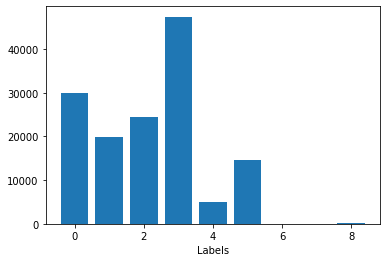

There are 6009 wake labels
There are 4946 REM labels
There are 4169 Stage_1 labels
There are 10846 Stage_2 labels
There are 1150 Stage_3 labels
There are 4030 Stage_4 labels
There are 0 Artifact labels
There are 0 Indeterminate labels
There are 0 Unknown labels 



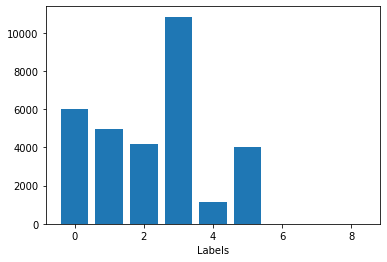

There are 357 wake labels
There are 439 REM labels
There are 410 Stage_1 labels
There are 1020 Stage_2 labels
There are 48 Stage_3 labels
There are 126 Stage_4 labels
There are 0 Artifact labels
There are 0 Indeterminate labels
There are 0 Unknown labels 



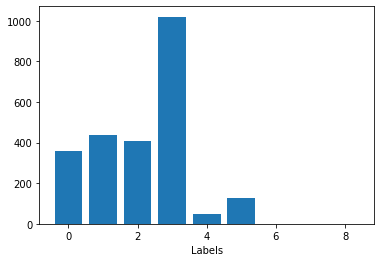

In [51]:
def show_label(label_input):
    print(f'There are {len(label_input[label_input == 0])} wake labels')
    print(f'There are {len(label_input[label_input == 1])} REM labels')
    print(f'There are {len(label_input[label_input == 2])} Stage_1 labels')
    print(f'There are {len(label_input[label_input == 3])} Stage_2 labels')
    print(f'There are {len(label_input[label_input == 4])} Stage_3 labels')
    print(f'There are {len(label_input[label_input == 5])} Stage_4 labels')
    print(f'There are {len(label_input[label_input == 6])} Artifact labels')
    print(f'There are {len(label_input[label_input == 7])} Indeterminate labels')
    print(f'There are {len(label_input[label_input == 8])} Unknown labels \n')


    unique_label = np.unique(label_input, return_counts=True)
    y_value = np.zeros(9)
    for i in range(len(unique_label[0])):
        y_value[int(unique_label[0][i])] = unique_label[1][i]
    plt.bar(np.arange(9), y_value)
    plt.xlabel('Labels')
    plt.show()

show_label(train_label_input)
show_label(val_label_input)
show_label(test_label_input)

In [10]:
def join_labels(label_input):
    for i in range(len(label_input)):
        label_input[label_input > 1] = 2
    print(f'There are {len(label_input[label_input == 0])} wake labels')
    print(f'There are {len(label_input[label_input == 1])} REM labels')
    print(f'There are {len(label_input[label_input == 2])} NREM labels \n')
    return label_input

train_label_input_join = join_labels(train_label_input)
val_label_input_join = join_labels(val_label_input)
test_label_input_join = join_labels(test_label_input)

In [12]:
def oversample_label(signal_input, label_input_join):
    os_signal_input = []
    os_label_input_join = []
    
    for i in range(len(label_input_join)):
        if len(label_input_join[i][label_input_join[i] == 1]) > 20:
            for _ in range(4):
                os_signal_input.append(signal_input[i])
                os_label_input_join.append(label_input_join[i])
        
        os_signal_input.append(signal_input[i])
        os_label_input_join.append(label_input_join[i])

    os_signal = np.asarray(os_signal_input)
    os_label = np.asarray(os_label_input_join)

    print(f'There are {len(os_label[os_label == 0])} wake labels')
    print(f'There are {len(os_label[os_label == 1])} REM labels')
    print(f'There are {len(os_label[os_label == 2])} NREM labels \n')
    print(f'shape of input signal {os_signal.shape}')
    print(f'shape of input label {os_label.shape} \n')

    return os_signal, os_label

os_train_signal, os_train_label = oversample_label(train_signal_input, train_label_input_join)
os_val_signal, os_val_label = oversample_label(val_signal_input, val_label_input_join)

#3.Model

##3.2 Model

###3.2.1 CNN+LSTM

In [14]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((os_train_signal, os_train_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signal_input, val_label_input_join))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [15]:
def cnn_1d(input_shape=None, dropout=0.2):
    
    x_input = Input(shape=input_shape)
    x = Conv1D(64, 21, strides=5, activation='relu')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 2nd Conv1D
    x = Conv1D(128, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 3rd Conv1D
    x = Conv1D(256, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 4th Conv1D
    x = Conv1D(512, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 5th Conv1D
    x = Conv1D(256, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)

    # Full connection layer
    out = Flatten()(x)

    model = Model(x_input, out, name='cnn_1d_layer')

    return model

In [16]:
def cnn_lstm(input_shape=(50,3840,1), classes=3):
    cnn = cnn_1d((3840,1))
    x_input = Input(shape=input_shape)
    x = TimeDistributed(cnn)(x_input)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    out = TimeDistributed(Dense(classes))(x)
    model = Model(x_input, out, name='cnn_lstm')

    return model

model = cnn_lstm(input_shape=(50,3840,1), classes=3)
model.summary()

Model: "cnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 3840, 1)]     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 10240)         1522944   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           5276160   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 64)            41216     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 3)             195       
Total params: 6,840,515
Trainable params: 6,838,083
Non-trainable params: 2,432
_________________________________________________________________


###3.2.2 Attention

In [14]:
n_a = 32 #Number of pre-LSTM states
n_s = 64 #Number of post-LSTM states
Tx = 50
Ty = 50
t_s0 = np.zeros((len(os_train_signal), n_s))
t_c0 = np.zeros((len(os_train_signal), n_s))
v_s0 = np.zeros((len(os_val_signal), n_s))
v_c0 = np.zeros((len(os_val_signal), n_s))

In [15]:
repeator = RepeatVector(Tx) 
concatenator = Concatenate(axis=-1) 
densor1 = Dense(10, activation = "tanh") 
densor2 = Dense(1, activation = "relu")
activator = Softmax(axis=1, name='attention_weights') 
dotor = Dot(axes = 1) 
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(3)

In [16]:
def cnn_1d(input_shape=None, dropout=0.2):
    
    x_input = Input(shape=input_shape)
    x = Conv1D(64, 21, strides=5, activation='relu')(x_input)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 2nd Conv1D
    x = Conv1D(128, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 3rd Conv1D
    x = Conv1D(256, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 4th Conv1D
    x = Conv1D(512, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(dropout)(x)
    # 5th Conv1D
    x = Conv1D(256, 5, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)

    # Full connection layer
    out = Flatten()(x)

    model = Model(x_input, out, name='cnn_1d_layer')

    return model

In [17]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    s_prev = repeator(s_prev)
    concat = concatenator([a,s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas,a])
    return context

In [18]:
def cnn_attention(Tx, Ty, n_a, n_s, input_image_size, classes):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    input_image_size -- size of the 30s ECG samples
    classes -- number of classes

    Returns:
    model -- Keras model instance
    """

    X_input = Input(shape=(Tx, input_image_size, 1))
    cnn = cnn_1d((3840,1))
    X = TimeDistributed(cnn)(X_input)

    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    for t in range(Ty):
    
        context = one_step_attention(a, s)

        s, _, c = post_activation_LSTM_cell(context,initial_state=[s, c])
        
        out = output_layer(s)
                
        outputs.append(out)
    
    
    model = Model(inputs=[X_input, s0, c0], outputs=outputs)
        
    return model

In [19]:
model = cnn_attention(Tx, Ty, n_a, n_s, 3840, 3)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 3840, 1) 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 50, 10240)    1522944     input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 64)       2629888     time_distributed[0][0]           
______________________________________________________________________________________________

##3.3 Training

In [ ]:
class CustomizedLoss(tf.keras.losses.Loss):
    def compute_loss(self, logits, positions):
        one_hot_positions = tf.one_hot(
            int(positions), depth=3)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        weight = tf.constant([1.,4.,1.])
        loss = -tf.reduce_mean(
            tf.reduce_sum(one_hot_positions * log_probs * weight, axis=-1))
        return loss
    
    def call(self, y_true, y_pred):
        loss = self.compute_loss(y_pred, y_true)
        return loss

###3.3.1 Train with distributed TPUs/GPUs

In [ ]:
with mirrored_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    
    batch_size = 16
    repeator = RepeatVector(Tx) 
    concatenator = Concatenate(axis=-1) 
    densor1 = Dense(10, activation = "tanh") 
    densor2 = Dense(1, activation = "relu")
    activator = Softmax(axis=1, name='attention_weights') 
    dotor = Dot(axes = 1)

    post_activation_LSTM_cell = LSTM(n_s, return_state = True)
    output_layer = Dense(3)

    model = cnn_attention(Tx, Ty, n_a, n_s, 3840, 3)
    
    ## tensorboard callback
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    %tensorboard --logdir logs
    ## early stop
    def decay(epoch):
        if epoch < 50:
            return 1e-4
        elif 50 <= epoch < 150:
            return 1e-5
        else:
            return 1e-6

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

    ## learning rate decay callback
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)

    callbacks_list = [tensorboard_callback, early_stop, lr_schedule]

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    history = model.fit(x=[os_train_signal, t_s0, t_c0],
                        y=list(os_train_label.swapaxes(0,1)),
                        epochs=100,
                        batch_size=16,
                        steps_per_epoch=len(os_train_signal)//batch_size,
                        verbose=1,
                        validation_data=([os_val_signal, v_s0, v_c0], 
                                         list(os_val_label.swapaxes(0,1))),
                        validation_batch_size=16,
                        validation_steps=len(os_val_signal)//batch_size,
                        callbacks=callbacks_list
                        )

In [ ]:
# Retrieve a list of list results on training and test data sets for each training epoch
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

###3.3.2 Train with single TPU/GPU

In [14]:
## tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
%tensorboard --logdir logs

## checkpoint callback
filepath = os.path.join("models",  "test-oversample-128Hz-{epoch:02d}-{loss:.4f}")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

## early stop
def decay(epoch):
    if epoch < 50:
        return 1e-3
    elif 50 <= epoch < 150:
        return 1e-4
    else:
        return 1e-5

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                              restore_best_weights=True)

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)

callbacks_list = [tensorboard_callback, checkpoint, early_stop, lr_schedule]

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit([os_train_signal, t_s0, t_c0],
          list(os_train_label.swapaxes(0,1)),
          epochs=100,
          batch_size=10,
          verbose=1,
          callbacks=callbacks_list
          )

#4.Evaluate Model

In [ ]:
# make predcitions
val_pred_raw = model.predict([os_val_signal, v_s0, v_c0])
val_pred = np.argmax(val_pred_raw, axis=-1)

##4.1 Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, class_names, normalize=False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.ylim(bottom=-0.5, top=2.5)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 1.5

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

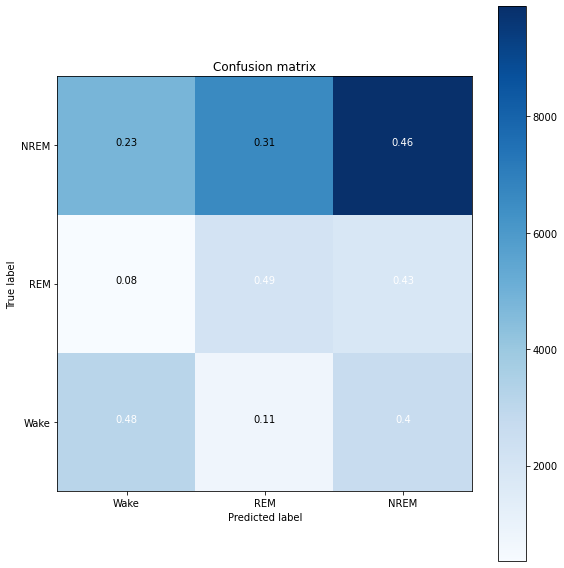

In [ ]:
class_names = ['Wake','REM','NREM']
cm = sklearn.metrics.confusion_matrix(val_label_input_join.flatten(), val_pred.flatten())
plot_confusion_matrix(cm, class_names=class_names, normalize=True)

##4.2 Cohen’s kappa coefficient

In [ ]:
sklearn.metrics.cohen_kappa_score(val_label_input_join.flatten(), val_pred.flatten())

0.28901251808963335

##4.3 Clinical parameters

In [ ]:
# total sleep time
# sleep efficiency
# sleep stage percentage
# AHI